In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import label_binarize
import time
import os

In [ ]:
OUTPUT_PATH = '/content/drive/MyDrive/processed_data'
preprocessing_info = np.load(os.path.join(OUTPUT_PATH, 'preprocessing_info.npy'),
                             allow_pickle=True).item()

IMG_SIZE = preprocessing_info['img_size']
NUM_CLASSES = preprocessing_info['num_classes']
CLASS_NAMES = preprocessing_info['class_names']
CLASS_WEIGHTS = preprocessing_info['class_weights']

print(f"Image Size: {IMG_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Classes: {CLASS_NAMES}")
print(f"Using: MobileNetV2 pre-trained on ImageNet")

Image Size: (224, 224)
Number of Classes: 5
Classes: ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']
Using: MobileNetV2 pre-trained on ImageNet


BUILD MOBILENET MODEL

In [ ]:
def build_mobilenet_transfer_learning(input_shape=(224, 224, 3), num_classes=5):
    """
    Build MobileNetV2 model with transfer learning

    Transfer Learning Strategy:
    1. Load MobileNetV2 pre-trained on ImageNet
    2. Freeze the base model layers initially
    3. Add custom classification head
    4. Fine-tune later for weather-specific features

    MobileNet Architecture Highlights:
    - Uses Depthwise Separable Convolutions (efficient)
    - Inverted Residual Structure (MobileNetV2)
    - Linear Bottlenecks (prevents information loss)
    - Width Multiplier (controls model size)
    - Designed for mobile and embedded devices
    - Only ~3.5M parameters (very lightweight!)
    """

    # Load pre-trained MobileNetV2 (without top classification layer)
    print("\nLoading MobileNetV2 pre-trained on ImageNet...")
    base_model = MobileNetV2(
        weights='imagenet',      # Use ImageNet pre-trained weights
        include_top=False,       # Don't include the top classification layer
        input_shape=input_shape,
        alpha=1.0,              # Width multiplier (1.0 = full model)
        pooling=None            # We'll add our own pooling
    )

    print(f"Base model loaded successfully!")
    print(f"Total layers in MobileNetV2: {len(base_model.layers)}")

    # Initially freeze all layers in the base model
    base_model.trainable = False
    print("Base model layers frozen (transfer learning mode)")

    # Build the complete model
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # Pre-trained MobileNetV2 base
        base_model,

        # Global Average Pooling (MobileNet design)
        layers.GlobalAveragePooling2D(name='global_avg_pool'),

        # Batch Normalization
        layers.BatchNormalization(name='bn1'),

        # Dense layer 1 (smaller than other models - MobileNet philosophy)
        layers.Dense(512, activation='relu',
                    kernel_regularizer=l2(0.001),
                    name='dense1'),
        layers.Dropout(0.5, name='dropout1'),

        # Dense layer 2
        layers.Dense(256, activation='relu',
                    kernel_regularizer=l2(0.001),
                    name='dense2'),
        layers.Dropout(0.3, name='dropout2'),

        # Output layer
        layers.Dense(num_classes, activation='softmax', name='predictions')
    ], name='MobileNetV2_Transfer_Learning')

    return model, base_model

# Build the model
print("\nBuilding MobileNetV2 with transfer learning...")
mobilenet_model, base_mobilenet = build_mobilenet_transfer_learning(
    input_shape=(*IMG_SIZE, 3),
    num_classes=NUM_CLASSES
)

# Display model summary
print("\n" + "="*70)
print("MODEL ARCHITECTURE SUMMARY")
print("="*70)
mobilenet_model.summary()

# Count parameters
total_params = mobilenet_model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in mobilenet_model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-trainable Parameters: {non_trainable_params:,}")
print(f"Percentage Trainable: {(trainable_params/total_params)*100:.2f}%")



Building MobileNetV2 with transfer learning...

Loading MobileNetV2 pre-trained on ImageNet...
Base model loaded successfully!
Total layers in MobileNetV2: 154
Base model layers frozen (transfer learning mode)

MODEL ARCHITECTURE SUMMARY


Model: "MobileNetV2_Transfer_Learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 1280)           │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,051,589 (11.64 MB)

 Trainable params: 791,045 (3.02 MB)

 Non-trainable params: 2,260,544 (8.62 MB)


Total Parameters: 3,051,589
Trainable Parameters: 791,045
Non-trainable Parameters: 2,260,544
Percentage Trainable: 25.92%


COMPILE MODEL

In [ ]:
# Use Adam optimizer for transfer learning
optimizer = optimizers.Adam(learning_rate=0.001)

mobilenet_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

SETUP CALLBACKS

In [ ]:
# Create directory for saving models
model_save_path = '/content/drive/MyDrive/models/mobilenet_transfer'
os.makedirs(model_save_path, exist_ok=True)

# Callbacks for Phase 1
callbacks_list = [
    # Save best model
    callbacks.ModelCheckpoint(
        filepath=os.path.join(model_save_path, 'mobilenet_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Reduce learning rate on plateau
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    # Early stopping
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # CSV logger
    callbacks.CSVLogger(
        os.path.join(model_save_path, 'training_log.csv'),
        append=False
    )
]

PREPARE DATA GENERATORS

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

DATASET_PATH = '/content/drive/MyDrive/weather_dataset/dataset'
BATCH_SIZE = 32

# Load split data
X_train = np.load(os.path.join(OUTPUT_PATH, 'X_train.npy'), allow_pickle=True)
X_val = np.load(os.path.join(OUTPUT_PATH, 'X_val.npy'), allow_pickle=True)
X_test = np.load(os.path.join(OUTPUT_PATH, 'X_test.npy'), allow_pickle=True)
y_train = np.load(os.path.join(OUTPUT_PATH, 'y_train.npy'), allow_pickle=True)
y_val = np.load(os.path.join(OUTPUT_PATH, 'y_val.npy'), allow_pickle=True)
y_test = np.load(os.path.join(OUTPUT_PATH, 'y_test.npy'), allow_pickle=True)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

def create_generator(datagen, X, y, batch_size, shuffle=True):
    df = pd.DataFrame({'filename': X, 'class': y.astype(str)})
    return datagen.flow_from_dataframe(
        dataframe=df, x_col='filename', y_col='class',
        target_size=IMG_SIZE, batch_size=batch_size,
        class_mode='sparse', shuffle=shuffle, seed=42
    )

train_generator = create_generator(train_datagen, X_train, y_train, BATCH_SIZE, True)
val_generator = create_generator(val_datagen, X_val, y_val, BATCH_SIZE, False)
test_generator = create_generator(test_datagen, X_test, y_test, BATCH_SIZE, False)

print(f"Training generator: {len(train_generator)} batches")
print(f"Validation generator: {len(val_generator)} batches")
print(f"Test generator: {len(test_generator)} batches")

Found 1050 validated image filenames belonging to 5 classes.
Found 300 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.
Training generator: 33 batches
Validation generator: 10 batches
Test generator: 5 batches


PHASE 1: TRAIN WITH FROZEN BASE

In [ ]:
EPOCHS_PHASE1 = 20

start_time_phase1 = time.time()

history_phase1 = mobilenet_model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=val_generator,
    callbacks=callbacks_list,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

time_phase1 = time.time() - start_time_phase1
print(f"\nPhase 1 training completed in {time_phase1/60:.2f} minutes")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.5172 - loss: 2.5085
Epoch 1: val_accuracy improved from -inf to 0.73000, saving model to /content/drive/MyDrive/models/mobilenet_transfer/mobilenet_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.5216 - loss: 2.4959 - val_accuracy: 0.7300 - val_loss: 1.7919 - learning_rate: 0.0010
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.8407 - loss: 1.5434
Epoch 2: val_accuracy improved from 0.73000 to 0.88000, saving model to /content/drive/MyDrive/models/mobilenet_transfer/mobilenet_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 723ms/step - accuracy: 0.8409 - loss: 1.5425 - val_accuracy: 0.8800 - val_loss: 1.4493 - learning_rate: 0.0010
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.8578 - loss: 1.4712
Epoch 3: val_accuracy improved from 0.88000 to 0.88667, saving model to /content/drive/MyDrive/models/mobilenet_transfer/mobilenet_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 780ms/step - accuracy: 0.8581 - loss: 1.4706 - val_accuracy: 0.8867 - val_loss: 1.3761 - learning_rate: 0.0010
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9071 - loss: 1.3433
Epoch 4: val_accuracy did not improve from 0.88667
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 673ms/step - accuracy: 0.9069 - loss: 1.3439 - val_accuracy: 0.8867 - val_loss: 1.3307 - learning_rate: 0.0010
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.8879 - loss: 1.3628
Epoch 5: val_accuracy improved from 0.88667 to 0.89667, saving model to /content/drive/MyDrive/models/mobilenet_transfer/mobilenet_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 717ms/step - accuracy: 0.8880 - loss: 1.3631 - val_accuracy: 0.8967 - val_loss: 1.3074 - learning_rate: 0.0010
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9109 - loss: 1.3033
Epoch 6: val_accuracy did not improve from 0.89667
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 675ms/step - accuracy: 0.9104 - loss: 1.3040 - val_accuracy: 0.8900 - val_loss: 1.3011 - learning_rate: 0.0010
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.8995 - loss: 1.2727
Epoch 7: val_accuracy improved from 0.89667 to 0.90000, saving model to /content/drive/MyDrive/models/mobilenet_transfer/mobilenet_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 685ms/step - accuracy: 0.8995 - loss: 1.2735 - val_accuracy: 0.9000 - val_loss: 1.2602 - learning_rate: 0.0010
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9164 - loss: 1.2809
Epoch 8: val_accuracy improved from 0.90000 to 0.92000, saving model to /content/drive/MyDrive/models/mobilenet_transfer/mobilenet_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 720ms/step - accuracy: 0.9168 - loss: 1.2797 - val_accuracy: 0.9200 - val_loss: 1.2163 - learning_rate: 0.0010
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9125 - loss: 1.2703
Epoch 9: val_accuracy did not improve from 0.92000
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 705ms/step - accuracy: 0.9128 - loss: 1.2699 - val_accuracy: 0.8767 - val_loss: 1.3418 - learning_rate: 0.0010
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.9124 - loss: 1.2008
Epoch 10: val_accuracy did not improve from 0.92000
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 670ms/step - accuracy: 0.9124 - loss: 1.2014 - val_accuracy: 0.9133 - val_loss: 1.2176 - learning_rate: 0.0010
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.9384 - loss: 1.1535
Epoch 11: val_accuracy did not improve from 0.92000

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 659ms/step - accuracy: 0.9383 - loss: 1.1533 - val

PHASE 2: FINE-TUNING

In [ ]:
# Unfreeze the base model for fine-tuning
base_mobilenet.trainable = True

# Freeze all layers except the last 30
print(f"Total layers in base model: {len(base_mobilenet.layers)}")
for layer in base_mobilenet.layers[:-30]:
    layer.trainable = False

# Count trainable parameters after unfreezing
trainable_params_phase2 = sum([tf.size(w).numpy() for w in mobilenet_model.trainable_weights])
print(f"Trainable parameters after unfreezing: {trainable_params_phase2:,}")
print(f"Percentage trainable: {(trainable_params_phase2/total_params)*100:.2f}%")

# Recompile with lower learning rate for fine-tuning
optimizer_phase2 = optimizers.Adam(learning_rate=0.0001)  # Lower LR

mobilenet_model.compile(
    optimizer=optimizer_phase2,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model recompiled with lr=0.0001 for fine-tuning")

# Update callbacks for phase 2
callbacks_list_phase2 = [
    callbacks.ModelCheckpoint(
        filepath=os.path.join(model_save_path, 'mobilenet_best_finetuned.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.CSVLogger(
        os.path.join(model_save_path, 'finetuning_log.csv'),
        append=False
    )
]

Total layers in base model: 154
Trainable parameters after unfreezing: 2,317,445
Percentage trainable: 75.94%
Model recompiled with lr=0.0001 for fine-tuning


In [ ]:
# Continue training with fine-tuning
EPOCHS_PHASE2 = 30

start_time_phase2 = time.time()

history_phase2 = mobilenet_model.fit(
    train_generator,
    epochs=EPOCHS_PHASE2,
    validation_data=val_generator,
    callbacks=callbacks_list_phase2,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

time_phase2 = time.time() - start_time_phase2
total_training_time = time_phase1 + time_phase2

print(f"\nPhase 2 (fine-tuning) completed in {time_phase2/60:.2f} minutes")
print(f"Total training time: {total_training_time/60:.2f} minutes")


Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.8776 - loss: 1.1428
Epoch 1: val_accuracy improved from -inf to 0.87333, saving model to /content/drive/MyDrive/models/mobilenet_transfer/mobilenet_best_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8782 - loss: 1.1415 - val_accuracy: 0.8733 - val_loss: 1.1801 - learning_rate: 1.0000e-04
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.9193 - loss: 1.0492
Epoch 2: val_accuracy improved from 0.87333 to 0.91667, saving model to /content/drive/MyDrive/models/mobilenet_transfer/mobilenet_best_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 756ms/step - accuracy: 0.9195 - loss: 1.0491 - val_accuracy: 0.9167 - val_loss: 1.1458 - learning_rate: 1.0000e-04
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.9347 - loss: 0.9780
Epoch 3: val_accuracy did not improve from 0.91667
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 765ms/step - accuracy: 0.9347 - loss: 0.9779 - val_accuracy: 0.9033 - val_loss: 1.1835 - learning_rate: 1.0000e-04
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9654 - loss: 0.9070
Epoch 4: val_accuracy did not improve from 0.91667
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 654ms/step - accuracy: 0.9652 - loss: 0.9072 - val_accuracy: 0.8633 - val_loss: 1.3761 - learning_rate: 1.0000e-04
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9572 - loss: 0.9499
Epoch 5: val_accuracy did not improve from 0.91667

Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 676ms/step - accuracy: 0.9574 - loss: 0.949

PLOT TRAINING HISTORY


Plotting training history...


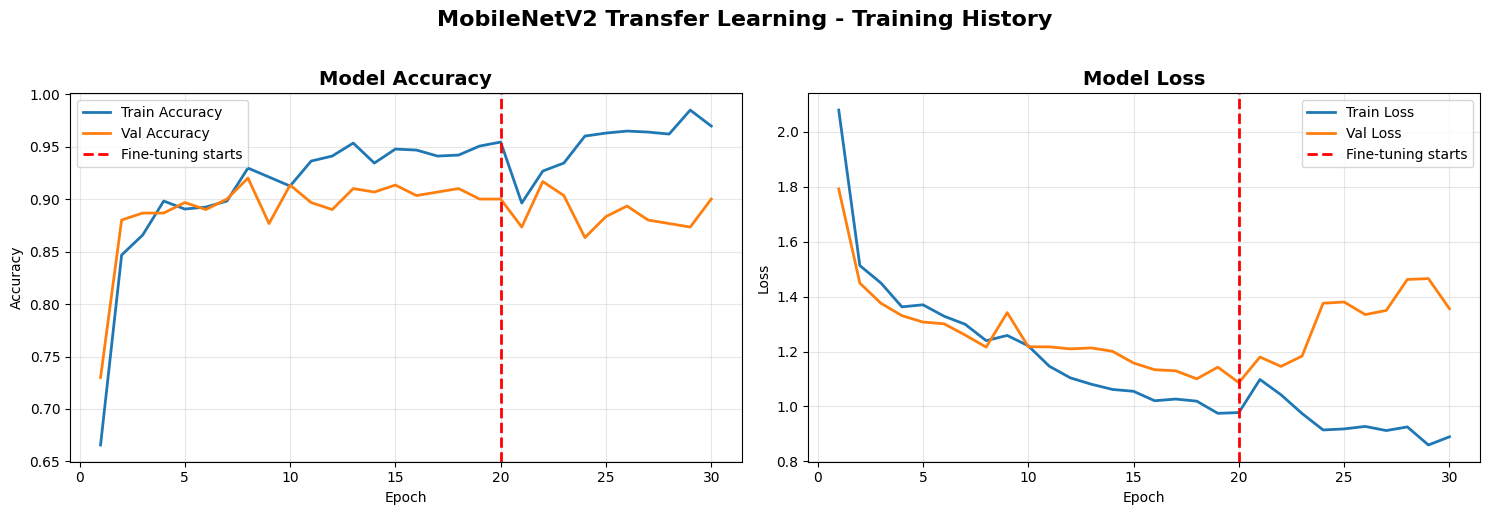

In [ ]:
def plot_training_history_phases(history1, history2, save_path):
    """Plot training history for both phases"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Combine histories
    epochs1 = len(history1.history['accuracy'])
    epochs2 = len(history2.history['accuracy'])
    total_epochs = epochs1 + epochs2

    train_acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    train_loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    # Accuracy plot
    axes[0].plot(range(1, total_epochs + 1), train_acc, label='Train Accuracy', linewidth=2)
    axes[0].plot(range(1, total_epochs + 1), val_acc, label='Val Accuracy', linewidth=2)
    axes[0].axvline(x=epochs1, color='red', linestyle='--', label='Fine-tuning starts', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(range(1, total_epochs + 1), train_loss, label='Train Loss', linewidth=2)
    axes[1].plot(range(1, total_epochs + 1), val_loss, label='Val Loss', linewidth=2)
    axes[1].axvline(x=epochs1, color='red', linestyle='--', label='Fine-tuning starts', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle('MobileNetV2 Transfer Learning - Training History', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

print("\nPlotting training history...")
plot_training_history_phases(history_phase1, history_phase2,
                             os.path.join(model_save_path, 'training_history.png'))


EVALUATE ON TEST SET

In [ ]:
# Evaluate
test_results = mobilenet_model.evaluate(test_generator, verbose=1)
test_loss = test_results[0]
test_accuracy = test_results[1]

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy:.4f}")

# Get predictions
print("\nGenerating predictions...")
test_generator.reset()
y_pred_probs = mobilenet_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test

# Calculate additional metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 953ms/step - accuracy: 0.8868 - loss: 1.2474

Test Results:
  Loss: 1.1837
  Accuracy: 0.8933

Generating predictions...


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
  Precision: 0.9012
  Recall: 0.8933
  F1-Score: 0.8923


CONFUSION MATRIX

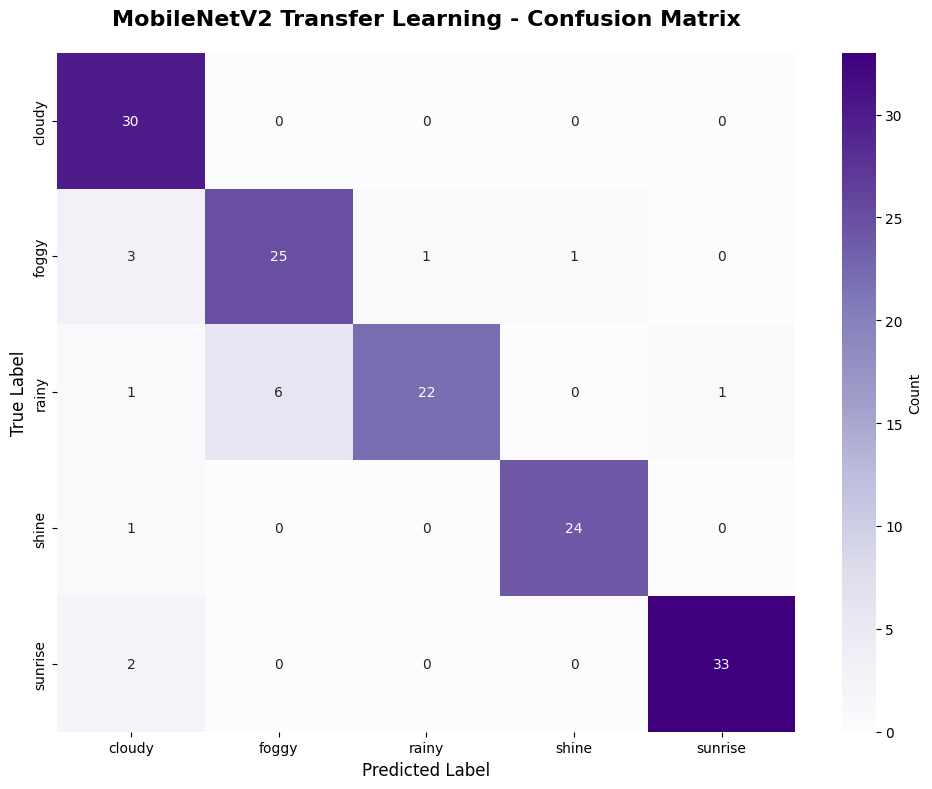

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('MobileNetV2 Transfer Learning - Confusion Matrix',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(model_save_path, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

              precision    recall  f1-score   support

      cloudy     0.8108    1.0000    0.8955        30
       foggy     0.8065    0.8333    0.8197        30
       rainy     0.9565    0.7333    0.8302        30
       shine     0.9600    0.9600    0.9600        25
     sunrise     0.9706    0.9429    0.9565        35

    accuracy                         0.8933       150
   macro avg     0.9009    0.8939    0.8924       150
weighted avg     0.9012    0.8933    0.8923       150



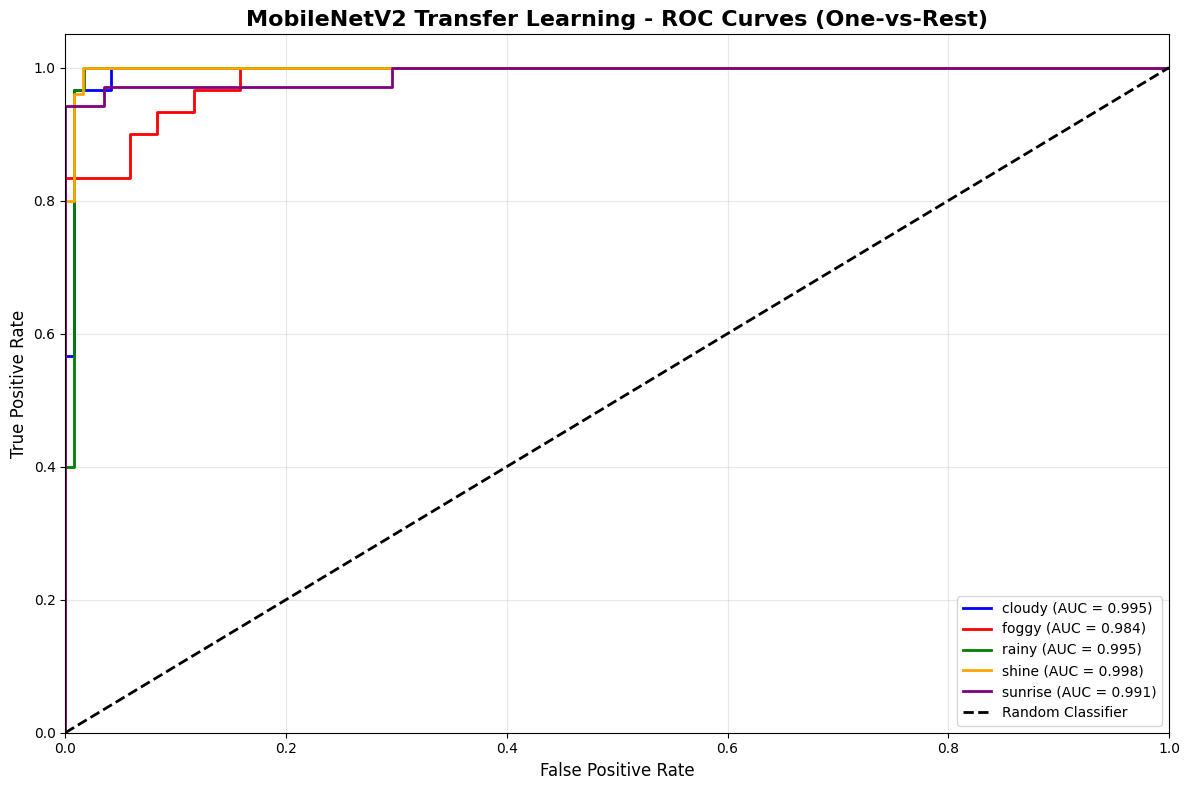


AUC Scores per Class:
  cloudy: 0.9953
  foggy: 0.9842
  rainy: 0.9947
  shine: 0.9981
  sunrise: 0.9906

Mean AUC: 0.9926


In [ ]:
# Binarize labels for ROC curve
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{CLASS_NAMES[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('MobileNetV2 Transfer Learning - ROC Curves (One-vs-Rest)',
          fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(model_save_path, 'roc_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print AUC values
print("\nAUC Scores per Class:")
for i in range(NUM_CLASSES):
    print(f"  {CLASS_NAMES[i]}: {roc_auc[i]:.4f}")
print(f"\nMean AUC: {np.mean(list(roc_auc.values())):.4f}")


COMPUTE MODEL EFFICIENCY METRICS

In [ ]:
# Calculate average inference time
print("\nMeasuring inference speed...")
test_generator.reset()
inference_times = []

for i in range(5):  # Average over 5 batches
    batch_images, _ = next(test_generator)
    start = time.time()
    _ = mobilenet_model.predict(batch_images, verbose=0)
    inference_times.append(time.time() - start)

avg_batch_time = np.mean(inference_times)
avg_image_time = avg_batch_time / BATCH_SIZE

print(f"Average inference time per batch ({BATCH_SIZE} images): {avg_batch_time:.4f} seconds")
print(f"Average inference time per image: {avg_image_time*1000:.2f} ms")
print(f"Throughput: {1/avg_image_time:.2f} images/second")



Measuring inference speed...
Average inference time per batch (32 images): 1.9300 seconds
Average inference time per image: 60.31 ms
Throughput: 16.58 images/second


SAVE RESULTS

In [ ]:
results = {
    'model_name': 'MobileNetV2 Transfer Learning',
    'architecture_note': 'Lightweight model with depthwise separable convolutions',
    'test_accuracy': float(test_accuracy),
    'test_precision': float(precision),
    'test_recall': float(recall),
    'test_f1_score': float(f1),
    'test_loss': float(test_loss),
    'auc_scores': {CLASS_NAMES[i]: float(roc_auc[i]) for i in range(NUM_CLASSES)},
    'mean_auc': float(np.mean(list(roc_auc.values()))),
    'training_time_minutes': float(total_training_time/60),
    'phase1_time_minutes': float(time_phase1/60),
    'phase2_time_minutes': float(time_phase2/60),
    'total_params': int(total_params),
    'trainable_params_phase1': int(trainable_params),
    'trainable_params_phase2': int(trainable_params_phase2),
    'inference_time_per_image_ms': float(avg_image_time * 1000),
    'throughput_images_per_second': float(1/avg_image_time),
    'confusion_matrix': cm.tolist(),
    'class_names': CLASS_NAMES
}

np.save(os.path.join(model_save_path, 'results.npy'), results)